# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [1]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
from influxdb import DataFrameClient
import pandas as pd
import numpy as np

import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.2
1.17.4
0.25.3


# Fetch Data

In [2]:
client = DataFrameClient(host='192.168.0.157', port=8086, database='metrics')
data =     client.query(
        '''
            SELECT 
                mean("value") 
            FROM "temperature" 
            WHERE 
                ("sensor_id" = 'RPI4-DHT22') 
                AND time >= now() - 90d 
            GROUP BY time(1h) fill(null);
        ''',
        bind_params={}, chunked=True, chunk_size=10000
    )

data = data['temperature']
data.columns = ['value']
data.describe()

,value
count,1698.000000
mean,24.514197
std,2.641563
min,17.413257
25%,22.552558
50%,24.372039
75%,26.589455
max,30.254950


In [3]:
df = data.dropna()
df_temp = df[['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-04 21:00:00+00:00', '2019-12-04 22:00:00+00:00',
               '2019-12-04 23:00:00+00:00', '2019-12-05 00:00:00+00:00',
               '2019-12-05 01:00:00+00:00', '2019-12-05 02:00:00+00:00',
               '2019-12-05 03:00:00+00:00', '2019-12-05 04:00:00+00:00',
               '2019-12-05 05:00:00+00:00', '2019-12-05 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1776, freq='H')

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


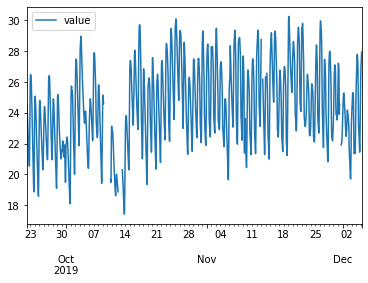

In [4]:
df_temp.plot()

# Differencing

In [5]:
df_diff = df_temp.diff().dropna()

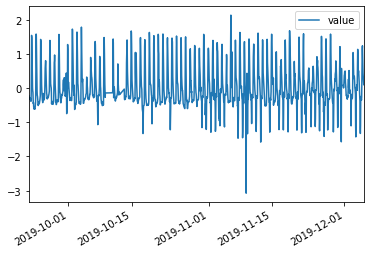

In [6]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [7]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 7.034252226472054e-05
Reject H0. Reject non-stationary. It could be stationary.


In [8]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 1.0852148610404774e-14
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [9]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.01
Reject H0. Reject stationary. It could be non-stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [10]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

In [11]:
df_acf = pd.DataFrame(stattools.acf(df_temp.dropna(), fft=True))

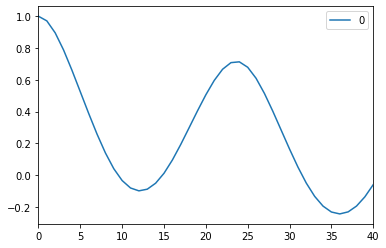

In [12]:
df_acf.plot()

In [13]:
df_pacf = pd.DataFrame(stattools.pacf(df_temp.dropna(), method='ols-inefficient'))

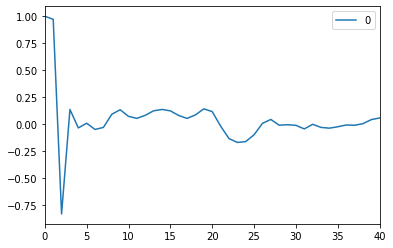

In [14]:
df_pacf.plot()

In [15]:
df_pacf[:6]

,0
0,1.000000
1,0.971411
2,-0.831225
3,0.136663
4,-0.034343
5,0.008786


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


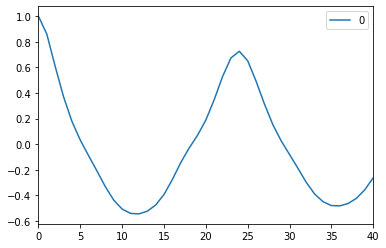

In [16]:
df_diff_acf = pd.DataFrame(stattools.acf(df_diff.dropna()))
df_diff_acf.plot()

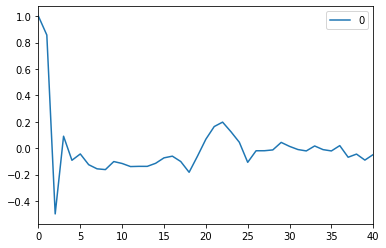

In [17]:
df_diff_pacf = pd.DataFrame(stattools.pacf(df_diff.dropna(), method='ols-inefficient'))
df_diff_pacf.plot()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [18]:
df_temp.to_csv("data.csv")

In [19]:
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-04 21:00:00+00:00', '2019-12-04 22:00:00+00:00',
               '2019-12-04 23:00:00+00:00', '2019-12-05 00:00:00+00:00',
               '2019-12-05 01:00:00+00:00', '2019-12-05 02:00:00+00:00',
               '2019-12-05 03:00:00+00:00', '2019-12-05 04:00:00+00:00',
               '2019-12-05 05:00:00+00:00', '2019-12-05 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1776, freq='H')

In [64]:
model = SARIMAX(df_temp['value'], order=(24,1,12))
results = model.fit()

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                 1776
Model:             SARIMAX(24, 1, 12)   Log Likelihood                 176.238
Date:                Thu, 05 Dec 2019   AIC                           -278.477
Time:                        18:16:02   BIC                            -75.659
Sample:                    09-22-2019   HQIC                          -203.556
                         - 12-05-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4709      0.234      2.013      0.044       0.012       0.929
ar.L2         -0.0954      0.262     -0.364      0.716      -0.608       0.418
ar.L3          0.0716      0.225      0.318      0.751      -0.370       0.513
ar.L4         -0.1203      0.226     -0.533      0.594      -0.563       0.322
ar.L5         -0.1714      0.254     -0.674      0.500      -0.670       0.327
ar.L6          0.0210      0.231      0.091      0.927      -0.431       0.473
ar.L7          0.0609      0.217      0.281      0.778      -0.364       0.485
ar.L8         -0.0533      0.198     -0.270      0.788      -0.441       0.334
ar.L9         -0.1350      0.204     -0.660      0.509      -0.536       0.266
ar.L10        -0.1083      0.204     -0.530      0.596      -0.508       0.292
ar.L11        -0.0667      0.182     -0.366      0.715      -0.424       0.291
ar.L12         0.2854      0.173      1.648      0.099      -0.054       0.625
ar.L13        -0.3248      0.142     -2.294      0.022      -0.602      -0.047
ar.L14         0.0699      0.088      0.792      0.428      -0.103       0.243
ar.L15        -0.1366      0.060     -2.279      0.023      -0.254      -0.019
ar.L16        -0.0404      0.051     -0.797      0.425      -0.140       0.059
ar.L17         0.0483      0.050      0.965      0.334      -0.050       0.146
ar.L18        -0.0276      0.045     -0.619      0.536      -0.115       0.060
ar.L19        -0.1086      0.043     -2.515      0.012      -0.193      -0.024
ar.L20        -0.0749      0.055     -1.364      0.173      -0.182       0.033
ar.L21        -0.0290      0.059     -0.491      0.624      -0.145       0.087
ar.L22         0.1328      0.050      2.643      0.008       0.034       0.231
ar.L23         0.0857      0.061      1.397      0.162      -0.035       0.206
ar.L24         0.1786      0.048      3.735      0.000       0.085       0.272
ma.L1          0.5693      0.233      2.445      0.014       0.113       1.026
ma.L2          0.1303      0.259      0.504      0.614      -0.377       0.637
ma.L3         -0.0687      0.234     -0.293      0.769      -0.528       0.391
ma.L4          0.0195      0.233      0.084      0.933      -0.437       0.476
ma.L5          0.1401      0.208      0.674      0.501      -0.267       0.548
ma.L6          0.0627      0.215      0.292      0.771      -0.359       0.484
ma.L7          0.0077      0.200      0.038      0.969      -0.385       0.401
ma.L8         -0.0139      0.184     -0.076      0.940      -0.374       0.346
ma.L9          0.0683      0.158      0.433      0.665      -0.241       0.377
ma.L10         0.1111      0.165      0.673      0.501      -0.213       0.435
ma.L11         0.0736      0.145      0.509      0.611      -0.210       0.357
ma.L12        -0.2681      0.138     -1.944      0.052      -0.538       0.002
sigma2         0.0461      0.001     43.594      0.000       0.044       0.048
=================================================================================

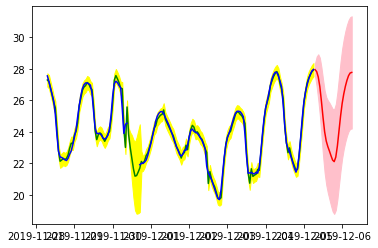

In [66]:
actual = df_temp[-168:]

prediction = results.get_prediction(start=-168, dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_ci = prediction.conf_int()

forecast = results.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure()



plt.plot(
    prediction_mean.index, 
    prediction_mean.values, 
    color='green', 
    label='prediction'
)
plt.fill_between(
    prediction_ci.index, 
    prediction_ci['lower value'], 
    prediction_ci['upper value'], 
    color='yellow'
)

plt.plot(
    forecast_mean.index, 
    forecast_mean.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    forecast_ci.index, 
    forecast_ci['lower value'], 
    forecast_ci['upper value'], 
    color='pink'
)

plt.plot(
    actual.index,
    actual['value'],
    color='blue', 
    label='actual'
)

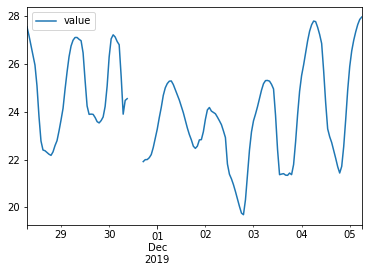

In [51]:
df_temp[-168:].plot()